<a href="https://colab.research.google.com/github/custom-hyper/Analytics/blob/main/Trading_Report_Uniswap_01-27-23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Environment

In [1]:
#@title Connect to FNS { display-mode: "code" }
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Install Dependencies
!pip install statistics --quiet
!pip install yfinance --quiet
!pip install pytrends --quiet
!pip install pycoingecko --quiet
!pip install pandas --quiet
!pip install Backtesting --quiet
!pip install mplfinance --quiet
!pip install configparser --quiet
!pip install psycopg2-binary==2.8.6 --quiet
!pip install tweepy==4.10.1 --quiet

#@title Ta-lib – Extra steps { display-mode: "code" }
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb 
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb 
!pip install ta-lib --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 KB 3.5 MB/s eta 0:00:00
Selecting previously unselected package libta-lib0.
(Reading database ... 129502 files and directories currently ins

In [3]:
#@title Import Project  Dependencies { display-mode: "code" }
import requests
import mplfinance as fplt
from datetime import datetime as dt
from datetime import timedelta
from datetime import date
import talib as ta
import time
import json
import seaborn as sns
from google.colab import data_table
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import logging
import sys
from tqdm.notebook import tqdm
import os
import sqlite3 as sq
import psycopg2 as pg
import configparser
from sqlalchemy import create_engine
from pycoingecko import CoinGeckoAPI
import numpy as np
#from __future__ import division

In [4]:

CoinGecko_id = "uniswap" #@param {type:"string"}
yahoo_id = "UNIc-USD" #@param {type:"string"}


In [5]:
#@title Set up SQLite { display-mode: "code" }
#@title  Connect { display-mode: "code" }
path = '/content/drive/MyDrive/workspace/pipelines/db/' #@param {type: 'string'
database = "db.sqlite" #@param {type: 'string'
conn_SQLite = sq.connect(path+database)

In [6]:
#@title  Load Watchlist { display-mode: "code" }

proprietary_watchlist_hist = 'proprietary_watchlist_hist'

df = pd.read_sql("""
select * 
from {}
WHERE
rel_volume	> 3
""".format(proprietary_watchlist_hist), conn_SQLite)



df

DatabaseError: ignored

# Big  Picture

Text(0.5, 1.0, 'Google Trends')

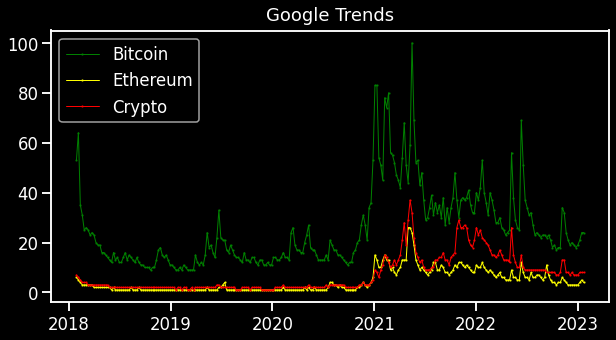

In [7]:
#@title
#@title Google Trends
import seaborn as sns
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
# Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()


pytrend.build_payload(kw_list=['Bitcoin', 'Ethereum','Crypto'])

# Interest Over Time
interest_over_time_df = pytrend.interest_over_time()
df=interest_over_time_df

plt.plot( 'Bitcoin', 'y1', data=df, marker='x', color='green',linestyle='-', linewidth=1,ms=1.5 )
plt.plot( 'Ethereum', 'y2', data=df, marker='x', color='yellow',linestyle='-', linewidth=1,ms=1.5 )
plt.plot( 'Crypto', 'y3', data=df, marker='x', color='red',linestyle='-', linewidth=1,ms=1.5 )

#plt.plot( 'Cosmos Crypto', 'y5', data=df, marker='x', color='red',linestyle='-', linewidth=1,ms=1.5 )
plt.legend()


# title
plt.title('Google Trends', loc='center',pad=10)


In [8]:
#@title
#@title Crypto Fear & Greed Index

import requests

from datetime import datetime
import time
import json
from google.colab import data_table
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt



#General Information table
response = requests.get("https://api.alternative.me/fng/?limit=0")
output = response.text
json_parsed = json.loads(output)

df = pd.json_normalize(json_parsed)


df1 = pd.concat([pd.json_normalize(x) for x in df['data'].values.tolist()])
timeseries = df1['timestamp']
df1['date'] = pd.to_datetime(df1['timestamp'], unit = 's')

df_fear_greed = pd.concat([df1['date'], df1['value']], axis=1)
df3 = pd.concat([df1['date'], df1['value_classification']])

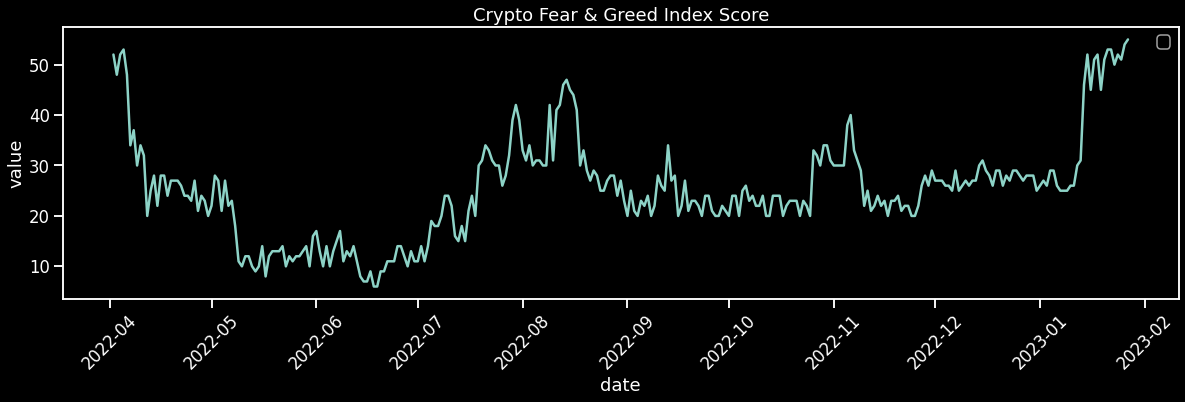

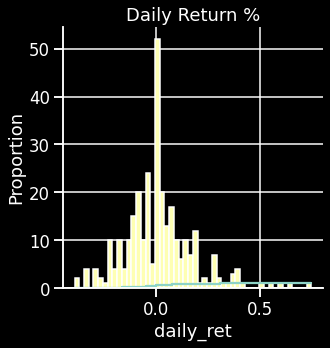

In [9]:
#@title
#@title


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.style.use("dark_background")
#sns.set_theme(style="darkgrid")

#Choose the date range
df_fear_greed = df_fear_greed[(df_fear_greed['date'] > '2022-04-01')]

df_fear_greed['value'] = df_fear_greed['value'].astype(int)
 
plt.figure(figsize=(20, 5))

sns.lineplot(data=df_fear_greed, linewidth=2.5, x="date", y="value", sort=False)
#sns.lineplot(df_fear_greed=df, linewidth=2.5, x="date", y="TotalCapMrktCurUSD")
plt.title('Crypto Fear & Greed Index Score')

plt.xticks(rotation=45)

plt.legend()


df_fear_greed.head(1)


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

df_fear_greed['daily_ret'] = df_fear_greed['value'].pct_change(1)

ECDF = sns.displot(df_fear_greed, x="daily_ret", kind="ecdf")

Histogram = df_fear_greed['daily_ret'].hist(bins = 50)


plt.title('Daily Return %')

plt.show()

# Technical Analysis

In [10]:
#@title S&P 500
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import talib as ta

ticker='SPY'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['longName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')


[*********************100%***********************]  1 of 1 completed


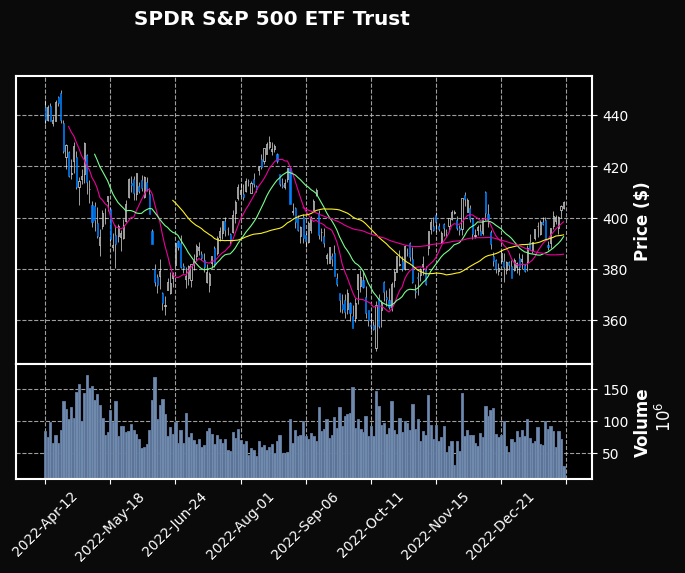

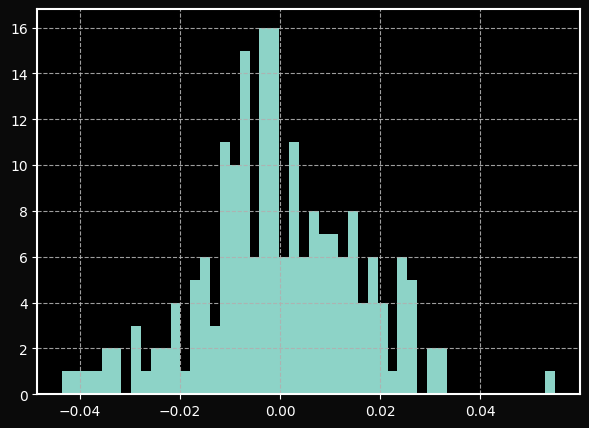

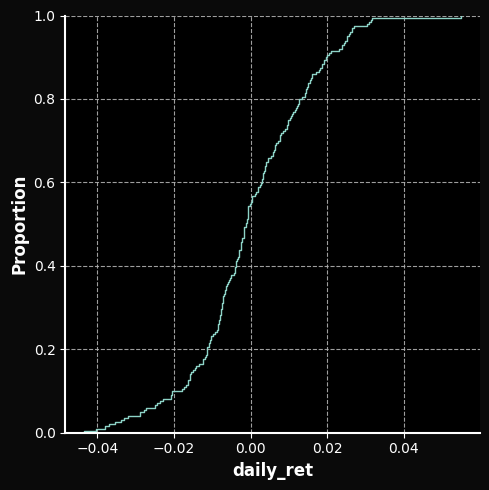

In [11]:
#@title
import mplfinance as fplt

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            mav = (10,20,50,100,200)
            )

data['daily_ret'] = data['Close'].pct_change(1)
data['daily_ret'].hist(bins = 50,figsize = (7,5))

sns.displot(data, x="daily_ret", kind="ecdf")



[*********************100%***********************]  1 of 1 completed


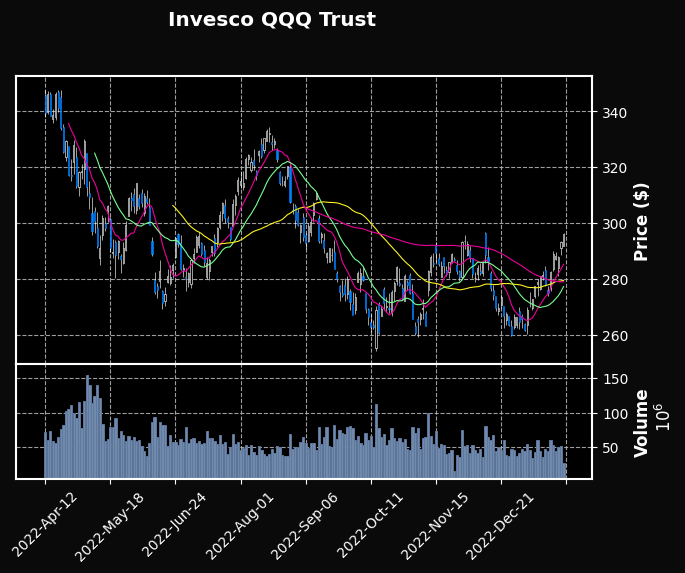

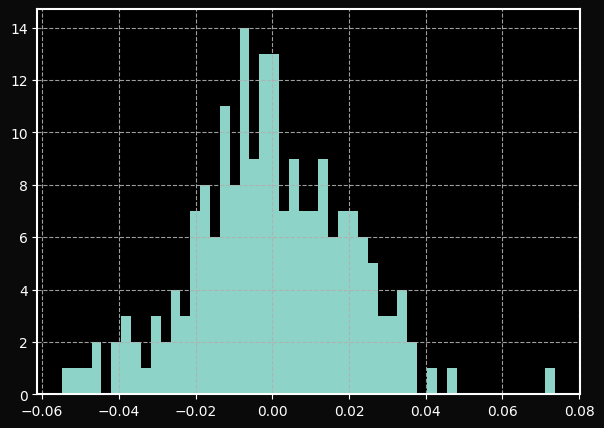

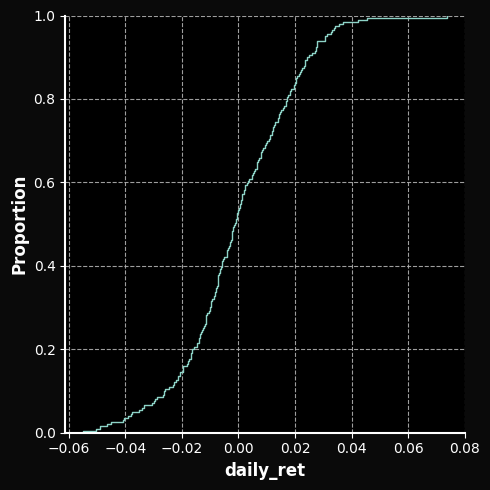

In [12]:
#@title  NASDAQ
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import talib as ta

ticker='QQQ'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['longName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')
#@title
import mplfinance as fplt

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            mav = (10,20,50,100,200)
            )

data['daily_ret'] = data['Close'].pct_change(1)
data['daily_ret'].hist(bins = 50,figsize = (7,5))

sns.displot(data, x="daily_ret", kind="ecdf")

[*********************100%***********************]  1 of 1 completed

Related News – ^VIX

– The S&P 500 is trying to top 4100, and the odds favor that happening by the end of January.
– Stock Market News for Jan 24, 2023
– Stock Market News for Jan 23, 2023
– Here Comes Key Economic Data and a Boatload of Earnings
– Stock Market News for Jan 20, 2023
– Profit Pain Is About to Give Another Jolt to Teetering Stocks
– Market check: S&P 500 sells off, volatility picks up


/usr/local/lib/python3.8/dist-packages/mplfinance/plotting.py:694: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


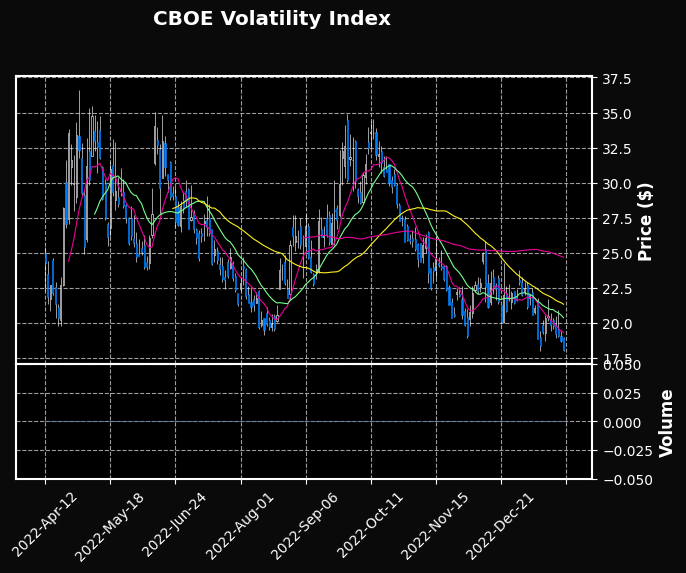

Text(0.5, 1.0, 'Daily Return %')

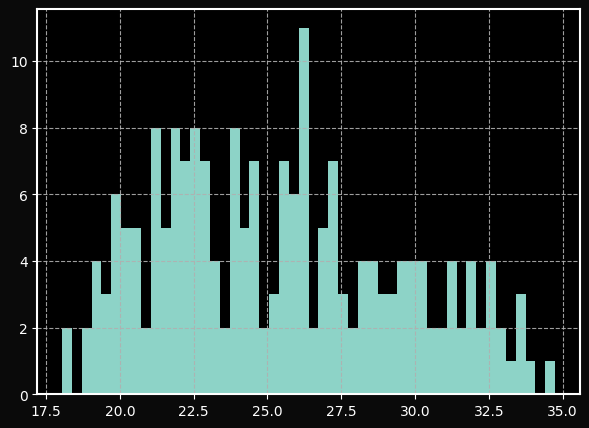

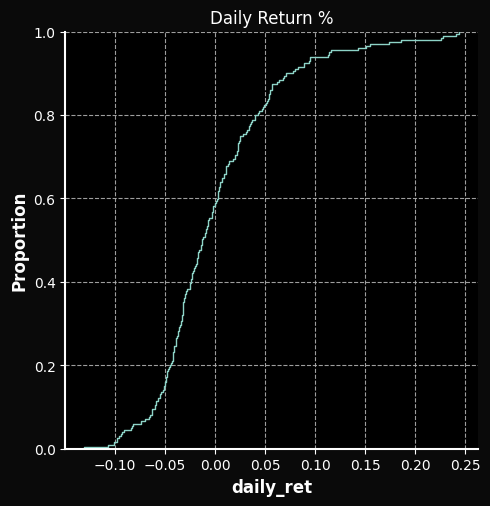

In [13]:
#@title  VIX
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

ticker='^VIX'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['shortName']

data = yf.download(tickers=ticker, period='200d')
print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass

import mplfinance as fplt

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            mav = (10,20,50,100,200)
            )

data['daily_ret'] = data['Close'].pct_change(1)
data['Close'].hist(bins = 50,figsize = (7,5))
sns.displot(data, x="daily_ret", kind="ecdf")


plt.title('Daily Return %')

/usr/local/lib/python3.8/dist-packages/mplfinance/plotting.py:694: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


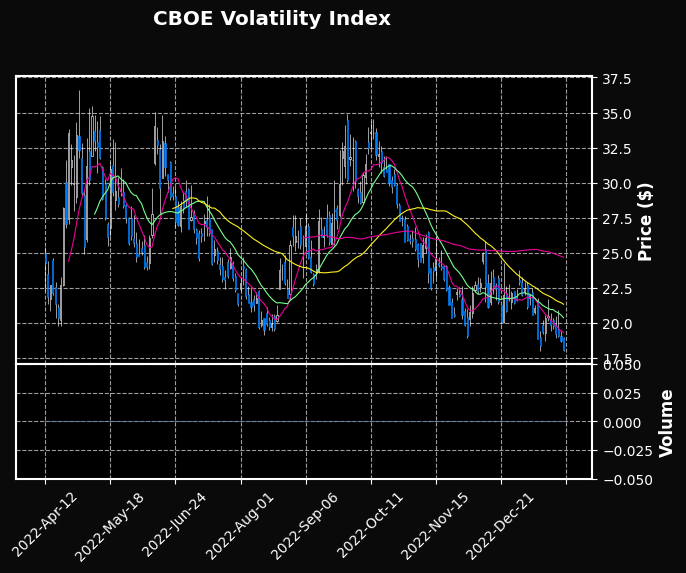

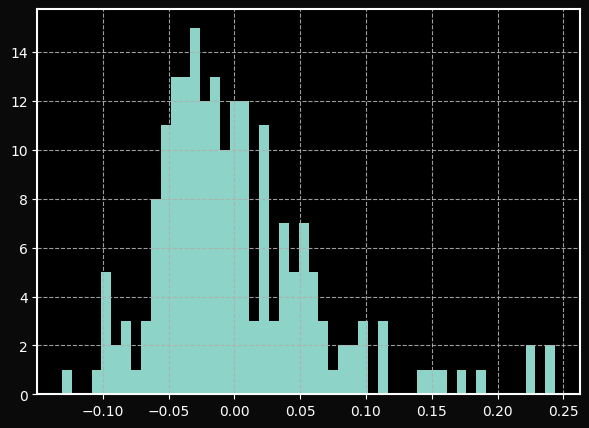

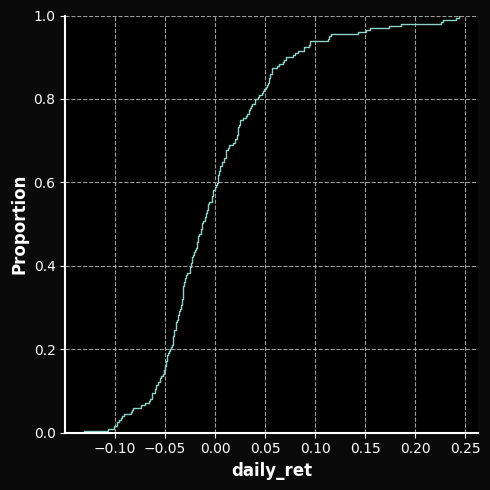

In [14]:
#@title

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            mav = (10,20,50,100,200)
            )


data['daily_ret'] = data['Close'].pct_change(1)
data['daily_ret'].hist(bins = 50,figsize = (7,5))
sns.displot(data, x="daily_ret", kind="ecdf")

[*********************100%***********************]  1 of 1 completed

Related News – BTC-USD



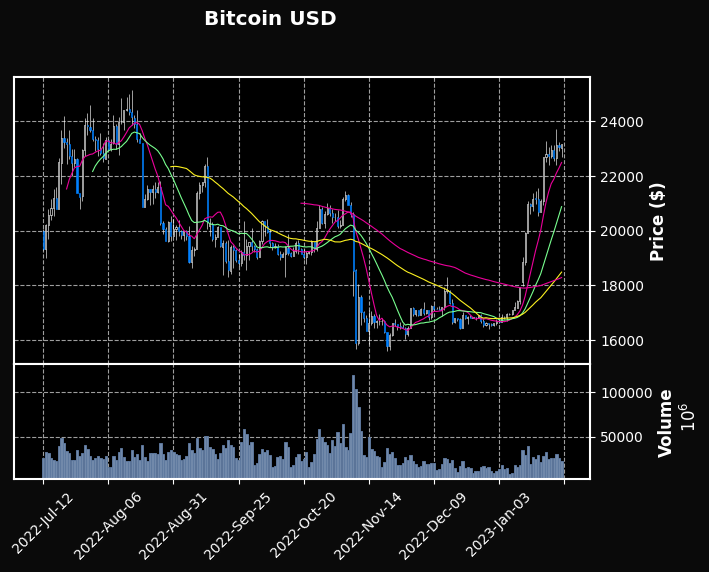

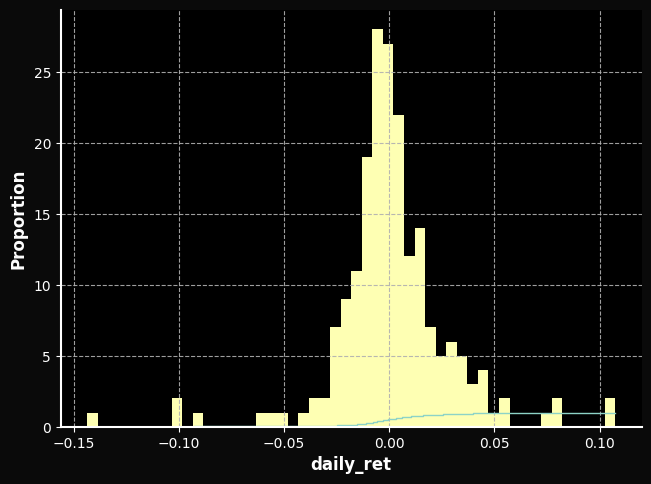

In [15]:
#@title Bitcoin
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

ticker='BTC-USD'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['shortName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')



print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass
  
fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            mav = (10,20,50,100,200)
            )
data['daily_ret'] = data['Close'].pct_change(1)

sns.displot(data, x="daily_ret", kind="ecdf")

data['daily_ret'].hist(bins = 50,figsize = (7,5))

[*********************100%***********************]  1 of 1 completed

Related News – ETH-USD

– Silver X To Participate in the Metals Investor Forum & Vancouver Resource Investment Conference
– Grace Young Wants to Keep Chinatown Restaurants in Business
– Fenty Beauty unveils Game Day Essentials Collection ahead of Rihanna's Super Bowl performance
– Stock Market Rally Powers Higher Amid Big Earnings From Tesla, Boeing, Microsoft, American Express: Weekly Review
– We Buy Houses Plano Texas: A Win-Win Solution for Tired Landlords and Burdensome Properties
– Jet fuel prices up as demand jumps, refinery outages limit supply
– Chronic Kidney Disease - Camfil Air Filtration Expert Discusses Disease and PM2.5 in Air Pollution


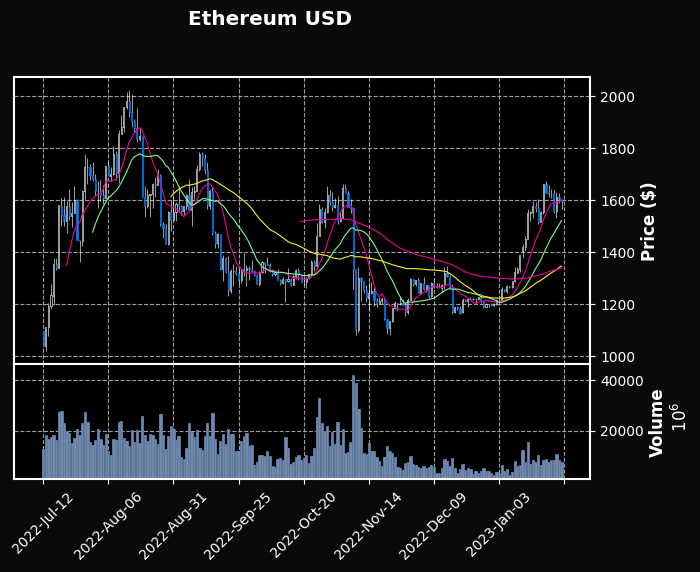

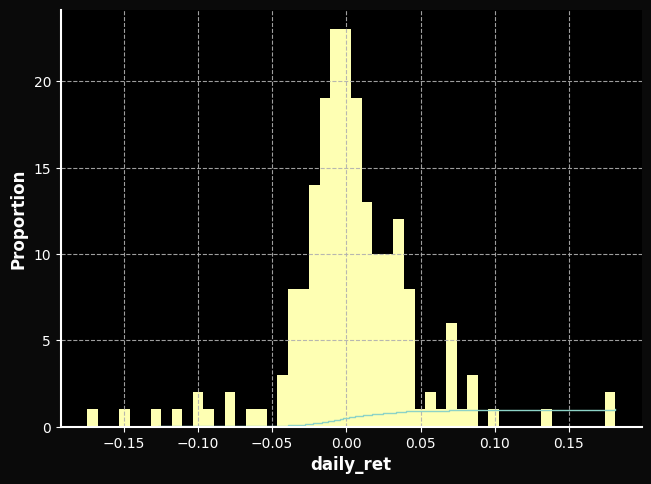

In [16]:
#@title Ethereum
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

ticker='ETH-USD'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['shortName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')



print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass

  
fplt.plot(
            data,
            type='candle',
            style='mike',
            title =Name,
            ylabel='Price ($)',
            volume=True,
            mav = (10,20,50,100,200),
            ylabel_lower='Volume',
            )

data['daily_ret'] = data['Close'].pct_change(1)

sns.displot(data, x="daily_ret", kind="ecdf")

data['daily_ret'].hist(bins = 50,figsize = (7,5))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DXY: Period '200d' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
[*********************100%***********************]  1 of 1 completed


<Figure size 640x480 with 0 Axes>

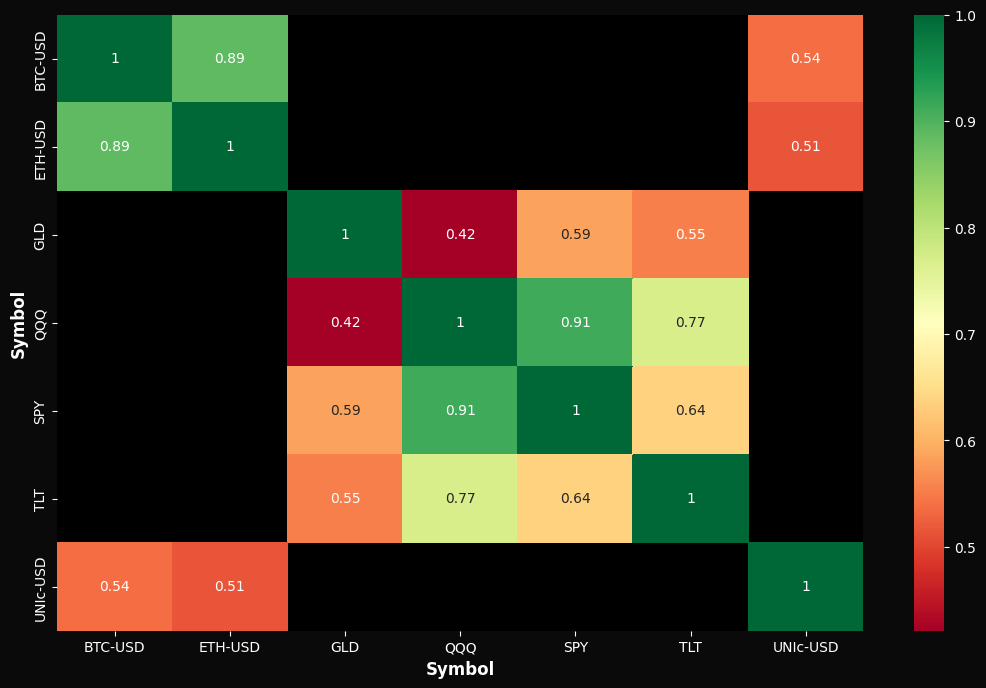

<Figure size 640x480 with 0 Axes>

In [17]:
#@title Correlation

import numpy as np 
import pandas as pd 
# Used to grab the stock prices, with yahoo 
import pandas_datareader as web 
from datetime import datetime 
# To visualize the results 
import matplotlib.pyplot as plt 
import seaborn

start = datetime(2022,9, 1)
symbols_list = [yahoo_id,'SPY', 'QQQ', 'ETH-USD', 'BTC-USD', 'TLT', 'DXY', 'GLD']
#array to store prices
symbols=[]

#array to store prices
symbols=[]
for ticker in symbols_list:     
    
    r = yf.download(tickers=ticker, period='200d')
    # add a symbol column   
    r['Symbol'] = ticker    
    symbols.append(r)
# concatenate into df
df = pd.concat(symbols)
df = df.reset_index()
df = df[['Date', 'Close', 'Symbol']]
df.head()
df_pivot=df.pivot('Date','Symbol','Close').reset_index()
df_pivot.head()
corr_df = df_pivot.corr(method='pearson')
#reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
#del corr_df.index.name
corr_df.head(10)
plt.figure(figsize=(13, 8))
seaborn.heatmap(corr_df, annot=True, cmap='RdYlGn')
plt.figure()

# Intraday Fundamentals

Connect to screener database

Trade Management

In [19]:
#@title Fundamentals

import requests
import datetime
import time
import json
from google.colab import data_table
from pycoingecko import CoinGeckoAPI
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq


cg = CoinGeckoAPI()

  
response = requests.get("https://api.coingecko.com/api/v3/coins/{}".format(CoinGecko_id))
output = response.text
json_parsed = json.loads(output)


x = json_parsed['market_data']['fully_diluted_valuation']

def fdv_none_val(x):
  """
    Calculating supply expansion multiple
    Requiring maximum supply and circulating supply
  """
  if x is None :
    fully_diluted_valuation = 0
  else :
    fully_diluted_valuation = json_parsed['market_data']['fully_diluted_valuation']
  
  return fully_diluted_valuation



def zero_div(x,y):
  """
  handling 0 division error
    
  """
  try:
      return x/y
  except ZeroDivisionError:
      return 0
links = 'Complete list: '+str(json_parsed['links'])
chat_url = 'Chat: '+str(json_parsed['links']['chat_url'])
CoinGecko_Link =  'CoinGecko: '+ "https://www.coingecko.com/en/coins/" + CoinGecko_id
Twitters = 'Twitter: '+str('https://twitter.com/')+str(json_parsed['links']['twitter_screen_name'])
homepage = 'Homepage: '+str(json_parsed['links']['homepage'])
subreddit_url =  'Reddit: ' +str(json_parsed['links']['subreddit_url'])
pd.set_option('display.width', 10)

print('')
print('WEB Links')
print('')
print(homepage)
print(Twitters)
print(subreddit_url)
print(chat_url)
print(CoinGecko_Link)

print(links)

print('')  
print('MARKET DATA')  
print('')  


market_cap = json_parsed['market_data']['market_cap']['usd']
circulating_supply = json_parsed['market_data']['circulating_supply']
# circulating_supply.astype(int) 
current_price = json_parsed['market_data']['current_price']['usd']
# current_price.astype(int) 
fdv_to_tvl_rati = json_parsed['market_data']['fdv_to_tvl_ratio']
# fdv_to_tvl_ratio.astype(int) 


#fully_diluted_valuation = json_parsed['market_data']['fully_diluted_valuation']['usd']

# fully_diluted_valuation
total_supply = json_parsed['market_data']['total_supply']
max_supply = json_parsed['market_data']['max_supply']
mcap_to_tvl_ratio = json_parsed['market_data']['mcap_to_tvl_ratio']
total_supply = json_parsed['market_data']['total_supply']
#total_value_locked = json_parsed['market_data']['total_value_locked']['usd']
total_volume = json_parsed['market_data']['total_volume']['usd']

float_rotation_24h = zero_div(total_volume , market_cap)
circulating_cap = current_price * json_parsed['market_data']['circulating_supply']
total_cap = current_price * total_supply


def max_cap(current_price, max_supply):
  """
    Calculation of maximum capitalization 
     Requiring current price and maximum supply
  """
  if max_supply is not None :
    max_cap = current_price * max_supply
  else :
    max_cap = 0
  return max_cap

max_cap = max_cap(current_price, max_supply)



def max_supply_expansion_multiple(circulating_supply, max_supply):
  """
    Calculating supply expansion multiple
    Requiring maximum supply and circulating supply
  """
  if max_supply is None :
    max_supply_expansion_multiple = 0
    
  elif circulating_supply ==  0:
    max_supply_expansion_multiple == 0
  
  else :
    max_supply_expansion_multiple = max_supply  / circulating_supply
  
  return max_supply_expansion_multiple


max_supply_expansion_multiple = max_supply_expansion_multiple(circulating_supply, max_supply)

def total_supply_expansion_multiple(circulating_supply, total_supply):
  """
    Calculating supply expansion multiple
    Requiring maximum supply and circulating supply
  """
  if total_supply is None :
    total_supply_expansion_multiple = 0
    
  elif circulating_supply == 0:
    total_supply_expansion_multiple == 0
  
  else :
    total_supply_expansion_multiple = total_supply  / circulating_supply
  
  return total_supply_expansion_multiple


"""
def market_cap_dilution_ratio(fully_diluted_valuation, market_cap):


  if fully_diluted_valuation or market_cap is None :
    market_cap_dilution_ratio == 0
    
  elif fully_diluted_valuation or market_cap is 0:
    market_cap_dilution_ratio == 0

  elif fully_diluted_valuation or market_cap is {}:
    market_cap_dilution_ratio == 0

  else :
    market_cap_dilution_ratio =  fully_diluted_valuation / market_cap
  
  return market_cap_dilution_ratio


market_cap_dilution_ratio = market_cap_dilution_ratio(fully_diluted_valuation, market_cap)
"""

print('')  

circulating_versus_max = circulating_supply/total_supply
dict_custom = {}
#dict_custom['total_supply_expansion_multiple'] = total_supply_expansionWhere_multiple
dict_custom['max_supply_expansion_multiple'] = max_supply_expansion_multiple
dict_custom['float_rotation_24h'] = float_rotation_24h

dict_custom['circulating_versus_max'] = circulating_versus_max


print(dict_custom)

df_market = {}
df_market['market_cap'] = market_cap
#Final been up what is on the national emergency, informative or what basket is something the P is the spaciousness up to Sarah  ankedat1['circulating_supply'] = circulating_supply
df_market['current_price'] = current_price
# df_market['fdv_to_tvl_ratio'] = fdv_to_tvl_ratio#
#df_market['fully_diluted_valuation'] = fully_diluted_valuation
# ankedat1['max_supply'] = max_supply
df_market['mcap_to_tvl_ratio'] = mcap_to_tvl_ratio
df_market['total_supply'] = total_supply
#df_market['total_value_locked'] = total_value_locked
df_market['mcap_to_tvl_ratio'] = mcap_to_tvl_ratio
df_market['total_volume'] = total_volume


print(df_market)




print('          ')  
print('PRICE ACTION')  
price_change_percentage_7d = json_parsed['market_data']['price_change_percentage_7d']
price_change_percentage_14d = json_parsed['market_data']['price_change_percentage_14d']
price_change_percentage_30d = json_parsed['market_data']['price_change_percentage_30d']
price_change_percentage_60d = json_parsed['market_data']['price_change_percentage_60d']
price_change_percentage_200d = json_parsed['market_data']['price_change_percentage_200d']
price_change_percentage_1y = json_parsed['market_data']['price_change_percentage_1y']



dict_return = {}
dict_return['price_change_percentage_7d'] = price_change_percentage_7d
dict_return['price_change_percentage_14d'] = price_change_percentage_14d
dict_return['price_change_percentage_30d'] = price_change_percentage_30d
dict_return['price_change_percentage_60d'] = price_change_percentage_60d
dict_return['price_change_percentage_200d'] = price_change_percentage_200d
dict_return['price_change_percentage_1y'] = price_change_percentage_1y

print(dict_return)



category = json_parsed['categories']

print('')  
print('CATEGORIES')  
print(category)
  



description  = [] 
pd.set_option('display.width', 10)
pd.set_option("display.max_rows", None, "display.max_columns", None)
description = json_parsed['description']['en']

print('')  
print('DESCRIPTION: ')
print(description)


links = json_parsed['links']

print('')  
print('LIQUIDITY: ')
print('')  

a = json_parsed['tickers']
data = pd.json_normalize(a,max_level=4)
df = pd.DataFrame(data)

df['pair'] = df['base'] + df['target'] 

df['market_and_volume'] = df['market.name']+ ' (' + df['volume'].round(1).rastype(str)+'), '
df['Exchanges'] = df.apply(lambda _: ', '.join(df['market_and_volume'] .tolist()), axis=1)
df['Exchanges'][1]
print(df)
df


WEB Links

Homepage: ['https://uniswap.org/', '', '']
Twitter: https://twitter.com/Uniswap
Reddit: https://www.reddit.com/r/Uniswap
Chat: ['https://discord.gg/FCfyBSbCU5', '', '']
CoinGecko: https://www.coingecko.com/en/coins/uniswap
Complete list: {'homepage': ['https://uniswap.org/', '', ''], 'blockchain_site': ['https://etherscan.io/token/0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'https://ethplorer.io/address/0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'https://blockscout.com/poa/xdai/tokens/0x4537e328Bf7e4eFA29D05CAeA260D7fE26af9D74/token-transfers', 'https://nearblocks.io/token/1f9840a85d5af5bf1d1762f925bdaddc4201f984.factory.bridge.near', 'https://hecoinfo.com/token/0x22c54ce8321a4015740ee1109d9cbc25815c46e6', 'https://bscscan.com/token/0xbf5140a22578168fd562dccf235e5d43a02ce9b1', 'https://polygonscan.com/token/0xb33eaad8d922b1083446dc23f610c2567fb5180f', 'https://snowtrace.io/token/0x8ebaf22b6f053dffeaf46f4dd9efa95d89ba8580', 'https://arbiscan.io/token/0xfa7f8980b0f1e64a206

AttributeError: ignored

In [20]:

#@title Charts

 
import datetime
import time
import json
from google.colab import data_table
from pycoingecko import CoinGeckoAPI
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq


cg = CoinGeckoAPI()

"""
1 - 2 days: 30 minutes
3 - 30 days: 4 hours
31 days and beyond: 4 days
"""
#chart  1
a = cg.get_coin_ohlc_by_id(id=CoinGecko_id, vs_currency='usd', days = 'max' )
df  = pd.DataFrame(data=a, columns = ['Date','Open','High', 'Low', 'Close'])
df['datetime'] = pd.to_datetime(df['Date'], unit='ms')
fig2 = go.Figure(data=[go.Candlestick(x=df['datetime'],open=df['Open'], high=df['High'],low=df['Low'], close=df['Close'])])                    
fig2.show()

#chart   2
b = cg.get_coin_ohlc_by_id(id=CoinGecko_id, vs_currency='usd', days = 180 )
df2  = pd.DataFrame(data=b, columns = ['Date','Open','High', 'Low', 'Close'])
df2['datetime'] = pd.to_datetime(df2['Date'], unit='ms')
fig3 = go.Figure(data=[go.Candlestick(x=df2['datetime'],open=df2['Open'], high=df2['High'],low=df2['Low'], close=df2['Close'])])                    
fig3.show()

#chart   3
b = cg.get_coin_ohlc_by_id(id=CoinGecko_id, vs_currency='usd', days = 30 )
df2  = pd.DataFrame(data=b, columns = ['Date','Open','High', 'Low', 'Close'])
df2['datetime'] = pd.to_datetime(df2['Date'], unit='ms')
fig3 = go.Figure(data=[go.Candlestick(x=df2['datetime'],open=df2['Open'], high=df2['High'],low=df2['Low'], close=df2['Close'])])                    
fig3.show()


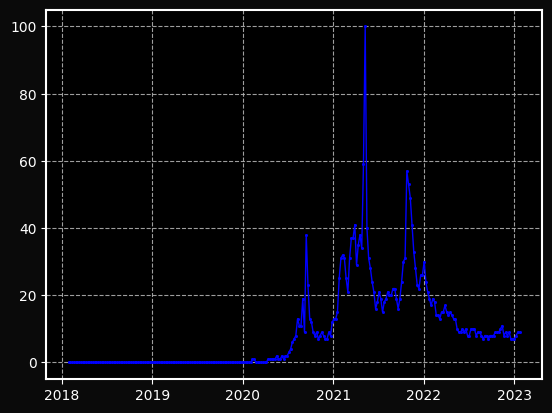

In [21]:
#@title Google Trends
pytrend = TrendReq()

# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
keyword = str(CoinGecko_id)
keyword = keyword.replace('-',' ')
pytrend.build_payload(kw_list=[keyword])


interest_over_time_df = pytrend.interest_over_time()
df_Google=interest_over_time_df

#print(interest_over_time_df.tail(10))
# multiple line plot
# multiple line plot
plt.plot( keyword, 'y1', data=df_Google, marker='x', color='blue',linestyle='-', linewidth=1,ms=1.5 )

In [22]:
#@title  Project Recent Tweets
import configparser
import tweepy

config_file = "/content/drive/MyDrive/workspace/config.ini"
config_obj = configparser.ConfigParser()
config_obj.read(config_file)

Twitter = config_obj["Twitter_API"]

consumer_key = Twitter["consumer_key"]
consumer_secret = Twitter["consumer_secret"]
access_token = Twitter["access_token"]
access_token_secret = Twitter["access_token_secret"]

pd.set_option('display.width', 10)

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

user_name =str(json_parsed['links']['twitter_screen_name'])

def twitter_rept(user_name):
    """
    
    Generating text data of recent tweets

    """
    
    user =  api.user_timeline(screen_name = user_name )

    for tweet in user:
      
        print(tweet.created_at)

        print(tweet.text)

        print("------------------------------------------------------------------") 
        print(Twitters)

    return 
    
twitter_rept(user_name)

2023-01-26 20:17:18+00:00
3/ If you gaze long enough into Uniswap v3 math, the math also gazes into you. https://t.co/PxUZBgqoVw
------------------------------------------------------------------
Twitter: https://twitter.com/Uniswap
2023-01-26 20:17:17+00:00
2/ Check out the blog to learn:

👉 What is Q Notation?
👉 How do I calculate the current exchange rate?
👉 How do tic… https://t.co/9Q4rOUZMCu
------------------------------------------------------------------
Twitter: https://twitter.com/Uniswap
2023-01-26 20:17:17+00:00
1/ We get a lot of questions about Uniswap v3 from:

💻 Devs building on Uniswap v3
📈 Analysts drawing insights
🔎 Re… https://t.co/VSPcEYxUhK
------------------------------------------------------------------
Twitter: https://twitter.com/Uniswap
2023-01-26 19:14:42+00:00
https://t.co/fNo9Q2cPVq
------------------------------------------------------------------
Twitter: https://twitter.com/Uniswap
2023-01-26 17:58:11+00:00
Last week we dove into the benefits of crypto

In [ ]:
t it

#Back test